In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import matplotlib.pyplot as plt
import pandas as pd
from rdkit import RDLogger
from pandarallel import pandarallel

import massspecgym.utils as utils

In [3]:
# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

pandarallel.initialize(nb_workers=6, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
with open(utils.hugging_face_download('molecules/MassSpecGym_retrieval_candidates_mass.json')) as f:
# with open('./MassSpecGym_retrieval_candidates_mass.json') as f:
    cands_mass = json.load(f)
cands_mass = pd.DataFrame({'smiles': cands_mass.keys(), 'cands': cands_mass.values()})

with open(utils.hugging_face_download('molecules/MassSpecGym_retrieval_candidates_formula.json')) as f:
# with open('./MassSpecGym_retrieval_candidates_formula.json') as f:
    cands_formula = json.load(f)
cands_formula = pd.DataFrame({'smiles': cands_formula.keys(), 'cands': cands_formula.values()})

## Number of candidates

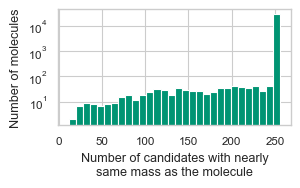

n_cands
256    27712
240        9
115        9
230        8
213        8
       ...  
30         1
55         1
193        1
82         1
89         1
Name: count, Length: 208, dtype: int64

In [24]:
cands_mass['n_cands'] = cands_mass['cands'].apply(len)
utils.init_plotting(figsize=(3, 1.5))
cands_mass['n_cands'].hist(bins=30)
plt.yscale('log')
plt.xlabel('Number of candidates with nearly\nsame mass as the molecule')
plt.ylabel('Number of molecules')
plt.savefig('n_cands_mass.svg', bbox_inches='tight')
plt.show()
cands_mass['n_cands'].value_counts()

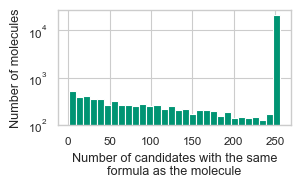

n_cands
256    21279
4         65
1         62
15        61
5         60
       ...  
226       11
247       11
175       10
229        9
255        7
Name: count, Length: 256, dtype: int64

In [25]:
cands_formula['n_cands'] = cands_formula['cands'].apply(len)
utils.init_plotting(figsize=(3, 1.5))
cands_formula['n_cands'].hist(bins=30)
plt.yscale('log')
plt.xlabel('Number of candidates with the same\nformula as the molecule')
plt.ylabel('Number of molecules')
plt.savefig('n_cands_formula.svg', bbox_inches='tight')
plt.show()
cands_formula['n_cands'].value_counts()

## Number of positive samples among candidates

In [5]:
def n_pos(row):
    inchi_true = utils.smiles_to_inchi_key(row['smiles'])
    return sum(utils.smiles_to_inchi_key(c) == inchi_true for c in row['cands'])

cands_mass['n_pos'] = cands_mass.parallel_apply(n_pos, axis=1)
cands_mass['n_pos'].value_counts()

n_pos
1    32010
Name: count, dtype: int64

In [6]:
def n_pos(row):
    inchi_true = utils.smiles_to_inchi_key(row['smiles'])
    return sum(utils.smiles_to_inchi_key(c) == inchi_true for c in row['cands'])

cands_formula['n_pos'] = cands_formula.parallel_apply(n_pos, axis=1)
cands_formula['n_pos'].value_counts()

n_pos
1    32010
Name: count, dtype: int64

## Analyze InChiKeys of queries

In [10]:
len(cands_mass['smiles']), cands_mass['smiles'].apply(utils.smiles_to_inchi_key).nunique()

(32010, 29294)